In [1]:
#-- Install Libraries -------------------------------------------------------------------------------------------
!pip install torchsummary
!pip install pytorchvideo

from IPython import display
display.clear_output()
#-----------------------------------------------------------------------------------------------------------------

In [2]:
#-- Imports ------------------------------------------------------------------------------------------------------
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

from torchsummary import summary

import cv2
import matplotlib.pyplot as plt

import numpy as np
import random

import os
import shutil
import copy

from glob import glob
#-----------------------------------------------------------------------------------------------------------------

In [3]:
#-- Initialize ---------------------------------------------------------------------------------------------------
ds_zip_path = '/kaggle/input/novin-fight-detection-slowfast-split-ds/ds.zip'
ds_unzip_path = '/kaggle/working/data/'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {DEVICE}')

BATCH_SIZE = 4
NUM_EPOCHS = 50
#-----------------------------------------------------------------------------------------------------------------

device: cuda


In [4]:
#-- unzip data ---------------------------------------------------------------------------------------------------
shutil.unpack_archive(ds_zip_path, ds_unzip_path, 'zip')
#-----------------------------------------------------------------------------------------------------------------

In [5]:
#-- Function to count number of samples is ds --------------------------------------------------------------------
def count_samples(data_dir):
    counts = {}
    
    for subset in ['train', 'val', 'test']:
        subset_path = os.path.join(data_dir, subset)
        counts[subset] = {}
        
        for category in ['Violence', 'NonViolence']:
            category_path = os.path.join(subset_path, category)
            num_samples = len(os.listdir(category_path))
            counts[subset][category] = num_samples
    
    return counts
#-----------------------------------------------------------------------------------------------------------------

In [6]:
#-- Dataset size -------------------------------------------------------------------------------------------------
sample_counts = count_samples(ds_unzip_path)

# Print the sample counts
for subset, categories in sample_counts.items():
    print(f"{subset} set:")
    for category, count in categories.items():
        print(f"  {category}: {count} samples")
#-----------------------------------------------------------------------------------------------------------------

train set:
  Violence: 105 samples
  NonViolence: 105 samples
val set:
  Violence: 30 samples
  NonViolence: 30 samples
test set:
  Violence: 15 samples
  NonViolence: 15 samples


In [7]:
#-- Dataset class for loading the videos ------------------------------------------------------------------------
class VideoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['Violence', 'NonViolence']
        self.frame_paths = []
        self.labels = []

        
        for label, class_name in enumerate(self.classes): 
            
            class_dir = os.path.join(root_dir, class_name)
            for frame_file in os.listdir(class_dir):
                frame_path = os.path.join(class_dir, frame_file)
                self.frame_paths.append(frame_path)
                self.labels.append(label)
                
                
                

    def __len__(self):
        return len(self.frame_paths)

    def __getitem__(self, idx):
        frame_path = self.frame_paths[idx]
        label = self.labels[idx]

        frames = torch.load(frame_path, weights_only=False)

        if self.transform:
            frames = self.transform(frames)

        return frames, torch.tensor(label, dtype=torch.long)
#-----------------------------------------------------------------------------------------------------------------

In [8]:
#-- Load Data ----------------------------------------------------------------------------------------------------
#-- Set the paths to dataset --
train_dir = ds_unzip_path + 'train'
val_dir = ds_unzip_path + 'val'
test_dir = ds_unzip_path + 'test'

#-- Create datasets for train, val, and test --
train_dataset = VideoDataset(root_dir=train_dir)
val_dataset = VideoDataset(root_dir=val_dir)
test_dataset = VideoDataset(root_dir=test_dir)

#-- Create DataLoaders --
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
#-----------------------------------------------------------------------------------------------------------------

In [9]:
#-- Check Data Loaders -------------------------------------------------------------------------------------------
for i, (videos, labels) in enumerate(train_loader):
        print(videos[0].shape, videos[1].shape, labels.shape)
        print(len(videos))
        break
#-----------------------------------------------------------------------------------------------------------------

torch.Size([4, 3, 8, 256, 256]) torch.Size([4, 3, 32, 256, 256]) torch.Size([4])
2


In [10]:
num__train_samples = len(train_loader.dataset)
num__val_samples = len(val_loader.dataset)
num__test_samples = len(test_loader.dataset)

print(f'Number of train samples in the DataLoader: {num__train_samples}')
print(f'Number of val samples in the DataLoader: {num__val_samples}')
print(f'Number of test samples in the DataLoader: {num__test_samples}')

Number of train samples in the DataLoader: 210
Number of val samples in the DataLoader: 60
Number of test samples in the DataLoader: 30


In [11]:
#-- Function to Modify SlowFast for finetuning ------------------------------------------------------------------------
def custome_SlowFast(num_classes):
    #-- load SlowFast model --
    model_name = 'slowfast_r50'
    model = torch.hub.load('facebookresearch/pytorchvideo', model_name, pretrained=True)   
    
     # Freeze all layers 
    for param in model.parameters():
        param.requires_grad = False
    
    #-- set last layer for binary classification --
    input_size = model.blocks[-1].proj.in_features
    model.blocks[-1].proj = nn.Linear(in_features=input_size, out_features=num_classes)   

    return model
#-----------------------------------------------------------------------------------------------------------------

In [12]:
#-- Function to Train Model --------------------------------------------------------------------------------------
def train(model, loader, optimizer, criterion):
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        
        slow_pathway, fast_pathway = inputs
        slow_pathway, fast_pathway, labels = slow_pathway.to(DEVICE), fast_pathway.to(DEVICE), labels.to(DEVICE)        

        optimizer.zero_grad()
        outputs = model([slow_pathway, fast_pathway])       
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        

    loss = running_loss / len(loader)
    accuracy = correct / total
    return loss , accuracy
#-----------------------------------------------------------------------------------------------------------------

In [13]:
#-- Function to Evaluate Model -----------------------------------------------------------------------------------
def evaluate(model, loader, criterion):
    model.eval()
    
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in loader:
            slow_pathway, fast_pathway = inputs
            slow_pathway, fast_pathway, labels = slow_pathway.to(DEVICE), fast_pathway.to(DEVICE), labels.to(DEVICE)        

            outputs = model([slow_pathway, fast_pathway])                 
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / len(loader)
    acc = correct / total
    return loss , acc
#-----------------------------------------------------------------------------------------------------------------

In [14]:
#-- Create and Initialize Model and its Params -------------------------------------------------------------------
num_classes = 2  # For Fighting and Normal
model = custome_SlowFast(num_classes).to(DEVICE)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
#-----------------------------------------------------------------------------------------------------------------

Downloading: "https://github.com/facebookresearch/pytorchvideo/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/SLOWFAST_8x8_R50.pyth" to /root/.cache/torch/hub/checkpoints/SLOWFAST_8x8_R50.pyth
100%|██████████| 264M/264M [00:00<00:00, 306MB/s]


In [15]:
#-- Display the model summary ------------------------------------------------------------------------------------
# summary(model, input_size=(3,16,256,256), device=DEVICE.type, batch_size=-1)
# print(model)
#-----------------------------------------------------------------------------------------------------------------

In [16]:
#-- Train Model -------------------------------------------------------------------------------------------------
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_model = None
best_acc = 0

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)    
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    if val_acc> best_acc:
        best_acc = val_acc
        best_model = copy.deepcopy(model)       
        
    
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, '
          f'Train Loss: {train_loss:.4f}, Train ACC: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val ACC: {val_acc:.4f}')    
    
    
last_model = copy.deepcopy(model)
#-----------------------------------------------------------------------------------------------------------------

Epoch 1/50, Train Loss: 0.4450, Train ACC: 0.7810, Val Loss: 0.1898, Val ACC: 0.9500
Epoch 2/50, Train Loss: 0.2259, Train ACC: 0.9429, Val Loss: 0.1358, Val ACC: 0.9667
Epoch 3/50, Train Loss: 0.1695, Train ACC: 0.9476, Val Loss: 0.1693, Val ACC: 0.9500
Epoch 4/50, Train Loss: 0.1771, Train ACC: 0.9429, Val Loss: 0.1221, Val ACC: 0.9500
Epoch 5/50, Train Loss: 0.1300, Train ACC: 0.9714, Val Loss: 0.1354, Val ACC: 0.9500
Epoch 6/50, Train Loss: 0.1225, Train ACC: 0.9619, Val Loss: 0.1185, Val ACC: 0.9500
Epoch 7/50, Train Loss: 0.1260, Train ACC: 0.9476, Val Loss: 0.1173, Val ACC: 0.9500
Epoch 8/50, Train Loss: 0.1358, Train ACC: 0.9571, Val Loss: 0.1508, Val ACC: 0.9333
Epoch 9/50, Train Loss: 0.0867, Train ACC: 0.9762, Val Loss: 0.1444, Val ACC: 0.9500
Epoch 10/50, Train Loss: 0.1368, Train ACC: 0.9524, Val Loss: 0.1617, Val ACC: 0.9333
Epoch 11/50, Train Loss: 0.0983, Train ACC: 0.9667, Val Loss: 0.1949, Val ACC: 0.9333
Epoch 12/50, Train Loss: 0.0732, Train ACC: 0.9810, Val Loss: 0

range(1, 51)


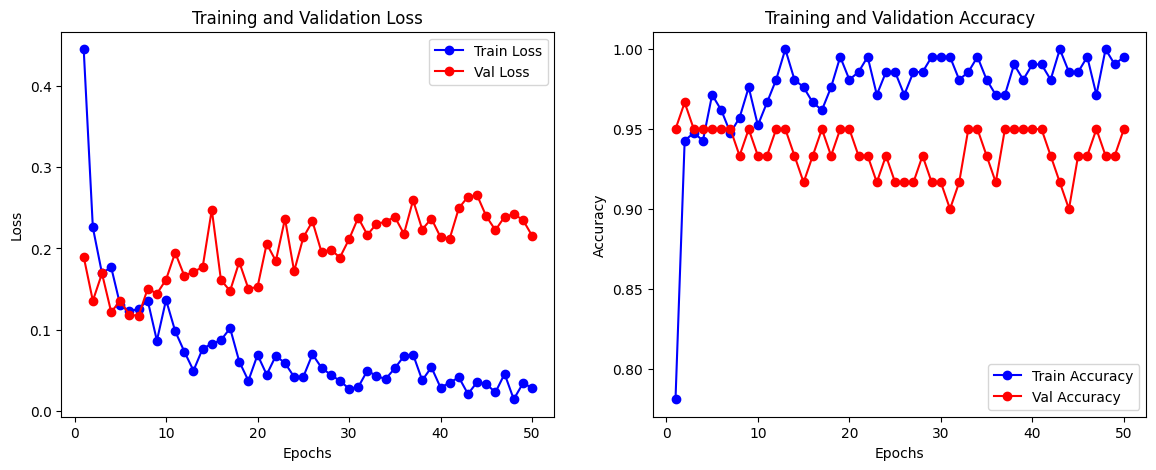

In [17]:
#-- Plot ACC and Loss --------------------------------------------------------------------------------------------
epochs = range(1, NUM_EPOCHS+1)
print(epochs)

plt.figure(figsize=(14, 5))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, val_losses, 'ro-', label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
#-----------------------------------------------------------------------------------------------------------------

In [18]:
#--Evaluate Model On Test Data --------------------------------------------------------------------------------
test_loss, test_acc = evaluate(best_model, test_loader, criterion)
print(f'Final Test Accuracy: {test_acc:.4f}')
#---------------------------------------------------------------------------------------------------------------

Final Test Accuracy: 0.9000
